I think one of the most important parts of making this classifier model is determining what, exactly, are the main nominal differences between r/nosleep and r/creepypasta? Do they serve the same communities? And within those communities, do they serve the same, or at least similar, purposes?

According to the responses to [this post](https://www.reddit.com/r/NoSleepOOC/comments/89etyy/whats_the_difference_between_a_no_sleep_and_a/), "creepypasta" is more of a general term encompassing scary/weird things on the internet, while r/nosleep is a subreddit specifically dedicated to original horror fiction.

Given this information, we believe that r/nosleep contains information that would be more relevant to the horror novel publisher's interests. However, the publisher was pushing hard for r/creepypasta, given that it's the horror subreddit they'd heard of first. We maintain that nosleep has better horror and fewer posters who write  inclinations. Let's develop a model that can tell the difference between the two subreddits to prove our hypothesis: that they have fundamentally different content and serve different sections of the horror community, and nosleep is objectively better for original content.

Importing libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier

Reading in my horror subreddit data:

In [2]:
horror = pd.read_csv('./Data/combo.csv')

Now, we're going to turn the subreddit column into 0s and 1s, with 1 = nosleep, and 0 = creepypasta.

In [3]:
horror['subreddit'] = horror.subreddit.map({'creepypasta' : 0, 'nosleep' : 1,})

In [4]:
horror.head()

,subreddit,title,selftext
0,1,Biter,"I hope I titled this right, because that's wh..."
1,1,Jacob,"As the new school year approached, my son’s f..."
2,1,The isolation,"\n\nSince I’ve been at home, I’ve been readi..."
3,1,Music Box,"When I was younger, I was super into all thing..."
4,1,A new Instagram influencer is obsessed with me...,Tiffany Fontaine. I loved her name because it ...


Assigning X and y variables:

In [4]:
X = horror['selftext']
y = horror['subreddit']

Let's get a gander at our baseline model:

In [5]:
y.value_counts(normalize = True)

0    0.510338
1    0.489662
Name: subreddit, dtype: float64

Okay, so if we predicted creepypasta (0) for every post, we'd be right 51% of the time.

We have a pretty close to even split in the subreddit column. I already knew that because I collected the data, but it's nice to see it all laid out in percentages. Now, I'll train-test split:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

I want to CountVectorize my data, but I also want to run a classifier model, so I'm going to use a pipeline. The classifier model I'm going to use first is Multinomial Naïve Bayes, because I want to calculate the probability that a given post is in nosleep given the words that are in the post. Let's get that started:

In [96]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

Okay, now I'm going to GridSearch over the CountVectorizer to determine the best parameters. I'm going to set the parameters dictionary first. I'm putting in max_df options of .5, .75, and .85 - keeping it relatively low to try to keep the best words. The max features don't need to be above 1,000 I don't THINK, but we'll test it at 2,000 as well. We'll include both 1- and 2-word n-grams, even though our previous results didn't bring up anything interesting with 2-word n-grams, but we'll throw it in there just in case.

In [71]:
params = {'cvec__max_features' : [1000, 2000],
          'cvec__min_df' : [.05, .10],
          'cvec__max_df' : [.5, .75, .85],
          'cvec__ngram_range' : [(1,1), (1,2)]}

I'll stratify my target variable for cross-val, because it's not a shuffled dataframe.

In [10]:
cv_folds = StratifiedKFold(shuffle = True, random_state = 42)

In [127]:
grid = GridSearchCV(pipe,
                  params,
                  cv = cv_folds,
                 verbose = 1,
                   n_jobs = -2)

In [128]:
X_train.shape

(1425,)

Okay, let's fit it! This is probably going to take a really long time!

In [129]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 120 out of 120 | elapsed:  3.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'cvec__max_df': [0.5, 0.75, 0.85],
                         'cvec__max_features': [1000, 2000],
                         'cvec__min_df': [0.05, 0.1],
                         'cvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

That's that! Let's see our best parameters:

In [130]:
grid.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 2000,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 1)}

Interestingly, the lowest max_df I chose became the best max_df for this particular model! Aaaand our scores:

In [131]:
grid.best_score_

0.6912280701754385

In [132]:
grid.score(X_test, y_test)

0.6927453769559033

Okay, so not a GREAT accuracy score, but certainly better than the baseline model, by about 18 percentage points! Let's look at a confusion matrix and the specificity of the model before we try another pipeline/model:

In [133]:
preds = grid.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

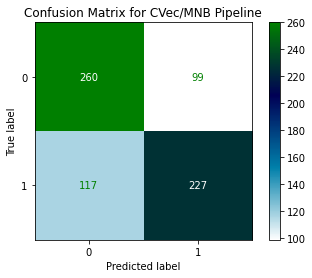

In [134]:
plot_confusion_matrix(grid, X_test, y_test, cmap='ocean_r', values_format='d')
plt.title('Confusion Matrix for CVec/MNB Pipeline');

Looks not so hot at first glance. Let's get the sensitivity (how right is this model for determining which post belongs in nosleep?):

In [135]:
tp / (tp + fn)

0.6598837209302325

Okay! All in all, not the world's best model, but as far as being better than the baseline, we've succeeded. This model is correct when it classifies posts as nosleep 66% of the time! It may be that it is inherently difficult to distinguish between these two subreddits, but I hold to my belief that nosleep is inherently better, so I don't think this is the best we can do.

I'm going to try a Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer in a pipeline with my MultinomialNB model. I'll see which one works better (TF-IDF or CountVectorizer), and following that, I'll use the better vectorizer with Logistic Regression and RandomForest and see what we get. Fingers crossed!

Setting up my pipeline with TF-IDF and Multinomial Naïve Bayes:

In [95]:
pipe_2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In setting up the parameters for my tvec pipeline, I'm going to set max_features at either 1,000, 2,000, or 3,000. The max_df will be .5, .75, and .85, and the n-gram range will include 1- and 2-word n-grams:

In [97]:
pipe_2_params = {
    'tvec__max_features' : [1000, 2000, 3000],
    'tvec__max_df' : [.5, .75, .85],
    'tvec__ngram_range' : [(1, 1), (1, 2)]
}

Now I'll GridSearch over that pipeline - once again, this will probably take a while! See you on the other side!

In [136]:
grid_2 = GridSearchCV(pipe_2,
                      pipe_2_params,
                      cv = cv_folds,
                      verbose = 1,
                      n_jobs = -2)

In [137]:
grid_2.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:  2.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'tvec__max_df': [0.5, 0.75, 0.85],
                         'tvec__max_features': [1000, 2000, 3000],
                         'tvec__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

Okay, let's look at the best parameters:

In [138]:
grid_2.best_params_

{'tvec__max_df': 0.5, 'tvec__max_features': 2000, 'tvec__ngram_range': (1, 1)}

Once again, the lowest max_df is the best parameter for these particular subreddits. Looking at the best score:

In [139]:
grid_2.best_score_

0.7501754385964913

Significantly better than the accuracy score from the CountVectorize grid! And a > 20 percentage point increase in accuracy from our baseline. A step in the right direction! Now we'll look at the confusion matrix and sensitivity.

In [140]:
preds_2 = grid_2.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_2).ravel()

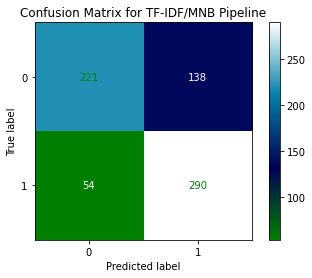

In [141]:
plot_confusion_matrix(grid_2, X_test, y_test, cmap='ocean', values_format='d')
plt.title('Confusion Matrix for TF-IDF/MNB Pipeline');

In [142]:
tp / (tp + fn)

0.8430232558139535

Fascinating! So, our accuracy score jumped by 5 points, but our specificity jumped from the CV model by almost 20 points! Because I'm optimizing for sensitivity (how right is my model when deciding which post is nosleep), I would classify this as a success.

Moving on to the RandomForest model. I'm hoping for big things. Now I know that TF-IDF is better for the specificity of my model, so I'll use that in this pipeline. But I'll still test different parameters, just in case different parameters are better with RandomForest than with MultinomialNB:

In [19]:
pipe_3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [20]:
pipe_3_params = {
    'tvec__max_features' : [2000, 3000],
    'tvec__max_df' : [.5, .75],
    'rf__n_estimators' : [70, 75, 100],
    'rf__max_features' : [None, 'auto'],
    'rf__max_depth' : [None, 5, 6]
}

Now we're fitting a few more models, so this will also take awhile! Catch you on the flip side:

In [21]:
grid_3 = GridSearchCV(pipe_3,
                      pipe_3_params,
                      cv = cv_folds,
                      verbose = 1,
                      n_jobs = -2)

In [22]:
grid_3.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-2)]: Done 360 out of 360 | elapsed: 43.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-2,
             param_grid={'rf__max_depth': [None, 5, 6],
                         'rf__max_features': [None, 'auto'],
                         'rf__n_estimators': [70, 75, 100],
                         'tvec__max_df': [0.5, 0.75],
                         'tvec__max_features': [2000, 3000]},
             verbose=1)

That was certainly something. Let's look at the best parameters:

In [23]:
grid_3.best_params_

{'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__n_estimators': 70,
 'tvec__max_df': 0.75,
 'tvec__max_features': 3000}

Very interesting! So, unlike the previous pipeline, our best tvec max df parameter here was .75. Looking at best score:

In [24]:
grid_3.best_score_

0.783859649122807

Okay! And, as I hoped, the accuracy score for our TF-IDF/RandomForest model was an improvement over the scores for the TF-IDF/MNB model, the CV/MNB model, and the baseline model! I think we've found our Prince Charmodel. Our knight in shining armodel. The Holy Gramodel. I'm not sorry about any of this, let's look at the confusion matrix and the sensitivity metric:

In [25]:
preds_3 = grid_3.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_3).ravel()

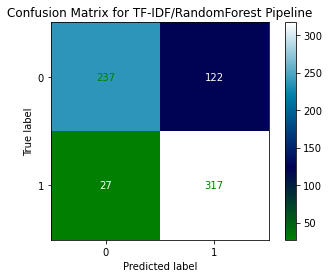

In [26]:
plot_confusion_matrix(grid_3, X_test, y_test, cmap='ocean', values_format='d')
plt.title('Confusion Matrix for TF-IDF/RandomForest Pipeline')
plt.savefig('confusion_rf.png', bbox_inches = 'tight');

In [27]:
tp / (tp + fn)

0.9215116279069767

Amazing. Beautiful. Best sensitivity score I've ever seen (in this notebook). To be clear, the sensitivity score is important to me because while I think there COULD be posts in r/creepypasta that are decent, original horror stories like the ones in r/nosleep, I think most of the posts in r/creepypasta are not that kind of high-quality original horror. Therefore, I would expect more r/creepypasta posts to be misidentified as r/nosleep posts than the opposite, so r/nosleep posts - my positive class - being correctly identified is more important to me.

Now, I'll try a pipeline with TF-IDF and basic Logistic Regression.

In [7]:
pipe_4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [8]:
pipe_4_params = {
    'tvec__max_features' : [2000, 3000],
    'tvec__max_df' : [.5, .75],
    'lr__C' : [1, 1.5, 2]
}

Okay, so now we'll fit this pipeline to our data. I'm expecting it to take some time, but not nearly as much as RandomForest. Let's see:

In [11]:
grid_4 = GridSearchCV(pipe_4,
                      pipe_4_params,
                      cv = cv_folds,
                      verbose = 1,
                      n_jobs = -2)

In [12]:
grid_4.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-3)]: Done  46 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-3)]: Done  60 out of  60 | elapsed:  1.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-3,
             param_grid={'lr__C': [1, 1.5, 2], 'tvec__max_df': [0.5, 0.75],
                         'tvec__max_features': [2000, 3000]},
             verbose=1)

Certainly didn't take as long! But is it as good? Let's see the best parameters:

In [13]:
grid_4.best_params_

{'lr__C': 1.5, 'tvec__max_df': 0.5, 'tvec__max_features': 3000}

In [15]:
grid_4.best_score_

0.7845614035087719

So, right off the bat, the best score is slightly worse than the RandomForest accuracy score. However, this model took 1 minute to run vs RandomForest's 45 minutes! Everything's a trade-off. Let's look at the confusion matrix and the sensitivity:

In [16]:
preds_4 = grid_4.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, preds_4).ravel()

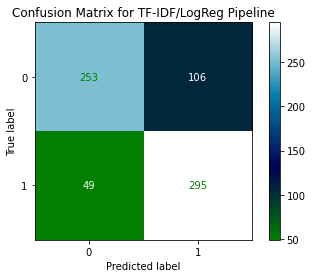

In [17]:
plot_confusion_matrix(grid_4, X_test, y_test, cmap='ocean', values_format='d')
plt.title('Confusion Matrix for TF-IDF/LogReg Pipeline');

In [18]:
tp / (tp + fn)

0.8575581395348837

Unfortunatley, the sensitivity is also significantly worse. So, for this particular data, TF-IDF and RandomForest appears to be the best combination.

So, now that we have a model that seems to be pretty decent at classifying which posts are from r/nosleep and which are from r/creepypasta, we can bring this to the horror novel publisher and let them know that r/nosleep and r/creepypasta are different enough that it matters, and that r/nosleep is almost certainly the better subreddit from which to mine ideas about trends in the horror industry and what audiences might be looking for.